# Digit Recognizer

In [46]:
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

from sklearn.decomposition import PCA

from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, classification_report

from collections import Counter


## Data Preprocessing

In [47]:
# Sử dụng dataset của Kaggle

train_df = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')

test_df = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')



print(train_df.shape)

print(test_df.shape) # tập dữ liệu kiểm tra, chưa có label

(42000, 785)
(28000, 784)


In [3]:
train_df

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
# split dataset in train.csv to x_train, x_test and y_train, y_test

from sklearn.model_selection import train_test_split


model_train_df = train_df.values

y_train_full = model_train_df[:,0]

x_train_full = model_train_df[:,1:]

x_train, x_test, y_train, y_test = train_test_split(x_train_full, y_train_full, test_size=0.2)


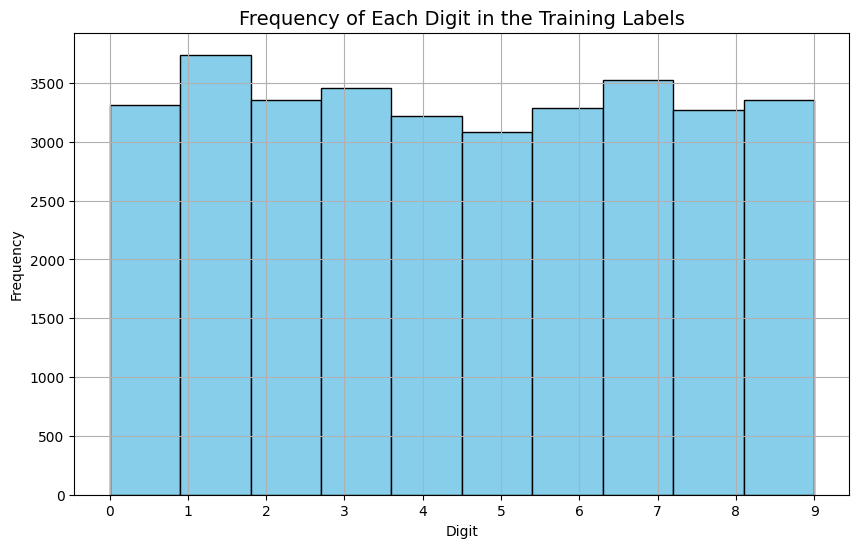

In [89]:
plt.figure(figsize=(10, 6))
plt.hist(y_train, bins=10, edgecolor='black', color='skyblue')  # Sử dụng histogram để vẽ
plt.title('Frequency of Each Digit in the Training Labels', fontsize=14)
plt.xlabel('Digit')
plt.ylabel('Frequency')
plt.grid(True)
plt.xticks(range(10))  # Đặt nhãn trục x là các số từ 0 đến 9
plt.show()

In [49]:
x_train.shape

(33600, 784)

In [50]:
x_test.shape

(8400, 784)

In [78]:
# Quan trọng: chuẩn hóa data mỗi pixel về [0,1]

x_train = x_train.astype('float32') / 255.0

x_test = x_test.astype('float32') / 255.0

x_test_final = test_df.values.astype('float32') / 255.0

In [79]:
# PCA
pca = PCA(n_components=49)  
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)
x_test_final_pca = pca.transform(x_test_final)

In [60]:
x_train_pca.shape

(33600, 49)

In [61]:
x_test_pca.shape

(8400, 49)

In [85]:
x_test_final_pca.shape

(28000, 49)

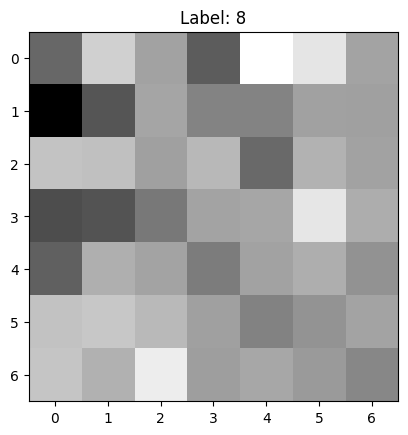

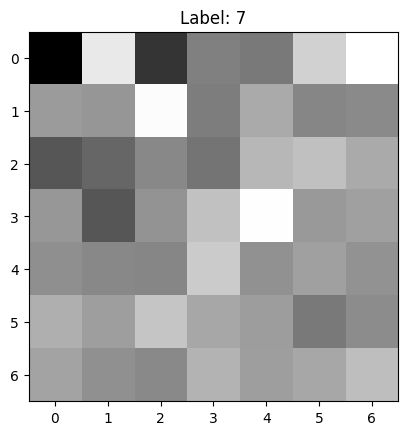

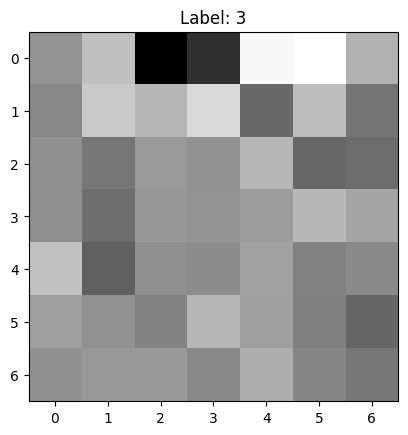

In [62]:
# Hiển thị 3 hình ảnh bất kỳ từ tập train

for index in range(0,3):

  plt.imshow(x_train_pca[index].reshape(7,7), cmap='gray') # Hiển thị ảnh dưới dạng thang độ xám

  plt.title(f"Label: {y_train[index]}")  # Hiển thị nhãn của ảnh

  plt.show()

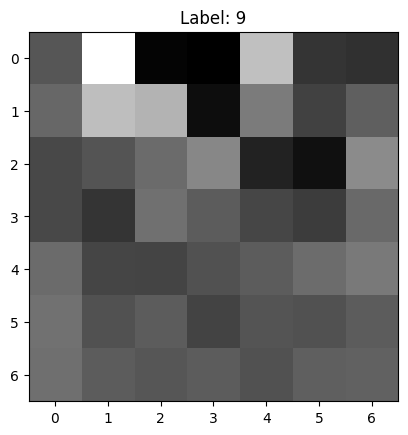

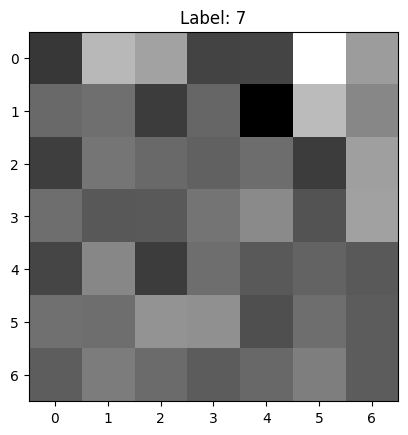

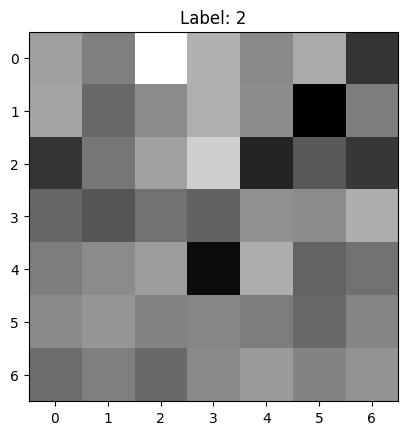

In [64]:
# Hiển thị 3 hình ảnh bất kỳ từ tập test

for index in range(0,3):

  plt.imshow(x_test_pca[index].reshape(7,7), cmap='gray') # Hiển thị ảnh dưới dạng thang độ xám

  plt.title(f"Label: {y_test[index]}")  # Hiển thị nhãn của ảnh

  plt.show()

## KNN



### Mathematical Theory:

- Tính khoảng cách từ điểm đầu vào tới tất cả các điểm trong tập train

- Tìm k điểm "hàng xóm" có distance nhỏ nhất => gần nhất

- Trong k hàng xóm đó, chọn nhãn xuất hiện nhiều nhất để quyết định nhãn cho điểm đầu vào. Tức là k hàng xóm gần nhất ở trong class nào nhiều thì sẽ cho điểm đầu vào vào class đó luôn

In [13]:
def euclide_distance(point1, point2):

  return np.sqrt(np.sum((point1 - point2)**2))



# test hàm

p1 = np.array([1,2,3])

p2 = np.array([4,5,6])



print(euclide_distance(p1,p2))

5.196152422706632


In [18]:
def knn(x_train, y_train, x, k):

  # tính các khoảng cách của điểm x so với từng điểm trong x_train

  distances = [euclide_distance(x, x_i) for x_i in x_train]

  k_indexes = np.argsort(distances)[:k] # lấy ra index của k hàng xóm gần nhất

  k_nearest_labels = [y_train[i] for i in k_indexes] # lấy ra nhãn của k hàng xóm gần nhất

  most_common = Counter(k_nearest_labels).most_common(1) # đếm nhãn xuất hiện nhiều nhất

  return most_common[0][0] # Counter trả về 1 tuple dạng (element, frequency) nên phải lấy [0][0]

In [16]:
def predict(x_test, x_train, y_train, k):

    predictions = []



    for test_point in x_test:

        pred_label = knn(x_train, y_train, test_point, k)

        predictions.append(pred_label)



    predictions = np.array(predictions)

    return predictions

In [69]:
def accuracy(predictions, y_test):

  accuracy = (predictions == y_test).sum() / y_test.shape[0]

  return accuracy

In [ ]:
predictions = predict(x_test_pca, x_train_pca, y_train, k = 5)

In [66]:
predictions

array([9, 7, 2, ..., 9, 1, 5])

In [68]:
y_test

array([9, 7, 2, ..., 9, 1, 5])

In [70]:
accuracy(predictions, y_test)

0.9767857142857143

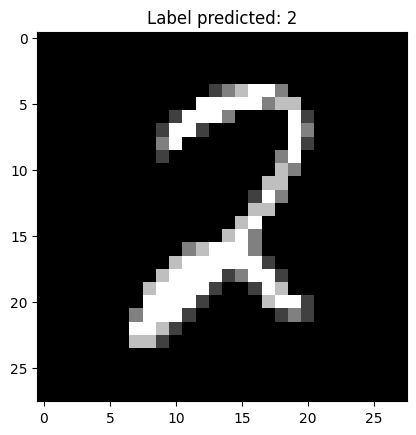

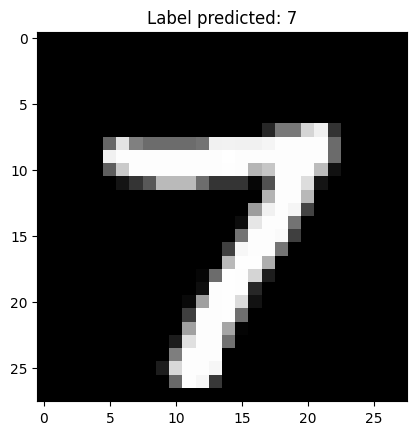

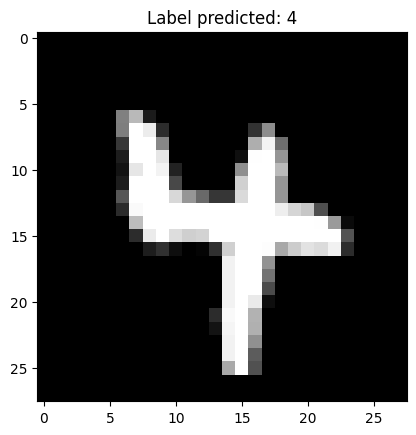

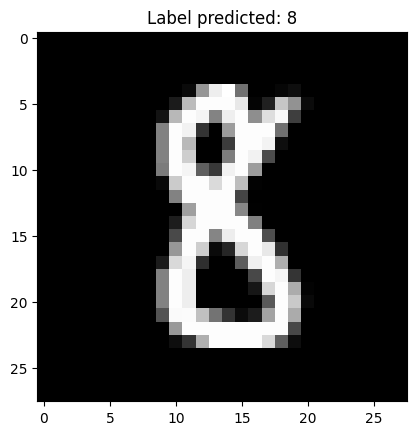

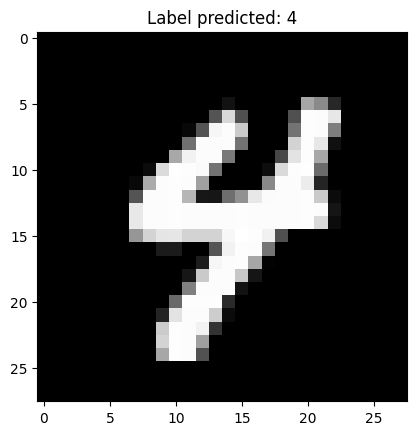

In [74]:
# kiểm tra 5 mẫu test bất kỳ

import random


# Tạo danh sách 5 số nguyên ngẫu nhiên trong khoảng 0 đến 8400

random_numbers = [random.randint(0, test_df.shape[0]) for _ in range(5)]


for index in random_numbers:

  plt.imshow(test_df.values[index].reshape(28,28), cmap='gray') # Hiển thị ảnh dưới dạng thang độ xám

  plt.title(f"Label predicted: {knn(x_train, y_train, test_df.values[index], k = 5)}")  # Hiển thị nhãn của ảnh

  plt.show()

## SVM



### Mathematical Theory



- SVM - Support Vector Machine có mục tiêu là tìm ra 1 mặt ngăn cách (thường là 1 siêu phẳng) tốt nhất để phân chia 2 class

- Một siêu phẳng tốt sẽ phải cho ra margin lớn nhất (margin là khoảng cách của điểm gần nhất của 1 class tới mặt phân chia)

- Do đó, bản chất toán học ở đây là tìm w và b (weight và bias của siêu phẳng) để tối ưu khoảng cách từ điểm gần nhất của mỗi class tới siêu phẳng đó.




In [ ]:
# Trong bài toán này, đối với mỗi class (mỗi loại chữ số), SVM tìm 1 siêu phẳng để phân chia class đó với các class còn lại

# Mỗi siêu phẳng sẽ quyết định là 1 điểm input sẽ thuộc hay không thuộc từng loại chữ số

# Có 10 siêu phẳng ứng với 10 loại chữ số từ 0 - 9

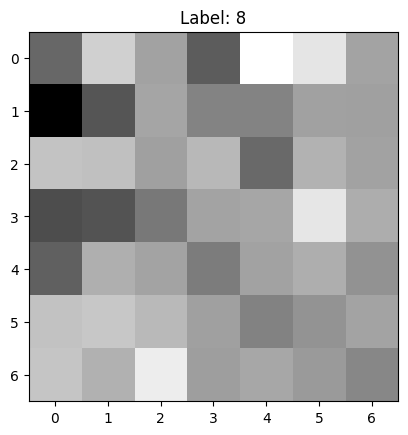

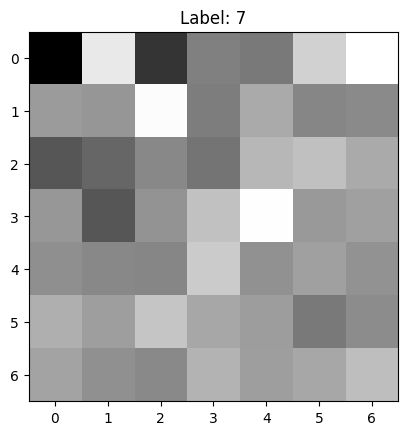

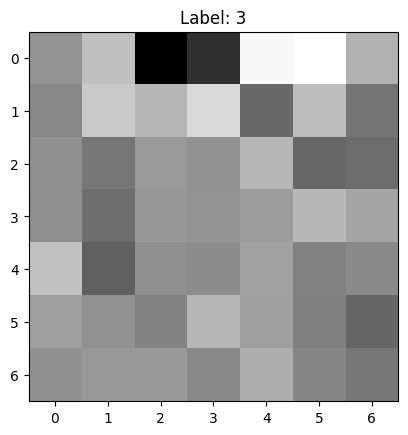

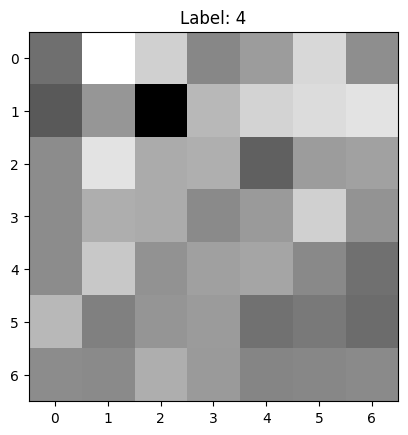

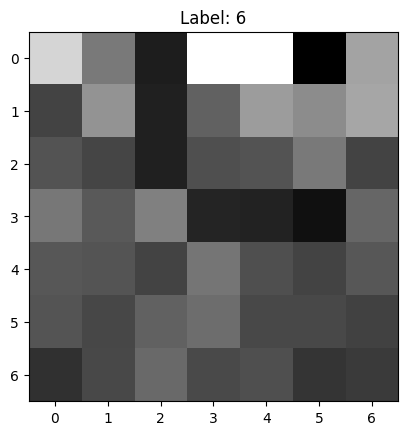

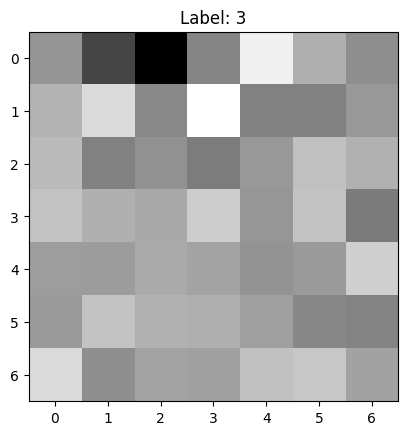

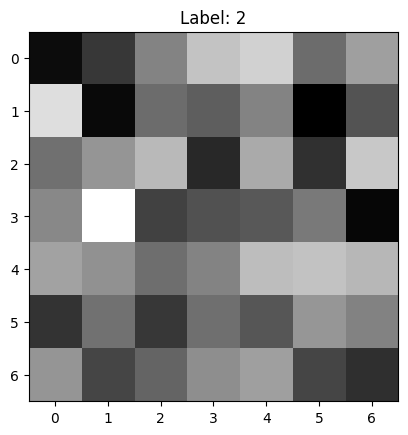

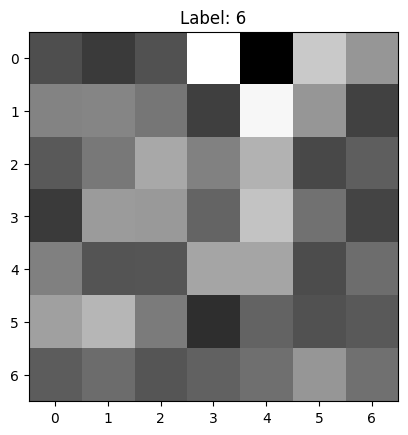

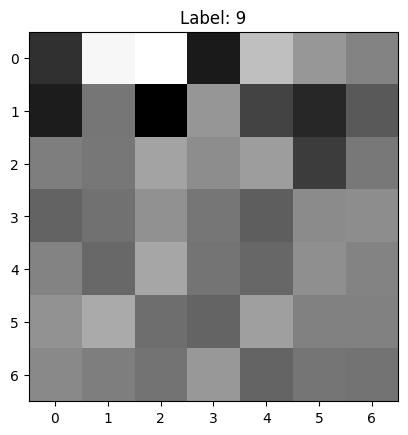

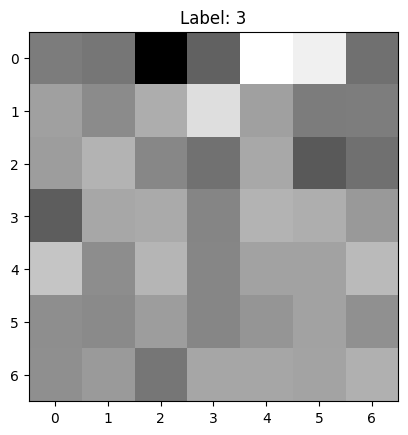

In [76]:
# Hiển thị 3 hình ảnh bất kỳ từ tập train

for index in range(0,10):

  plt.imshow(x_train_pca[index].reshape(7,7), cmap='gray') # Hiển thị ảnh dưới dạng thang độ xám

  plt.title(f"Label: {y_train[index]}")  # Hiển thị nhãn của ảnh

  plt.show()

In [77]:
# Train SVM model
print("Training SVM...")
svm = SVC(kernel='rbf', C=10, gamma=0.05, random_state=42)  # SVM with RBF kernel
svm.fit(x_train_pca, y_train)

# Predictions
print("Predicting...")
y_pred = svm.predict(x_test_pca)

Training SVM...
Predicting...


In [84]:
# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9835


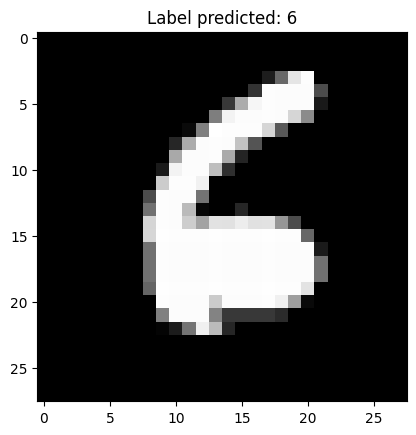

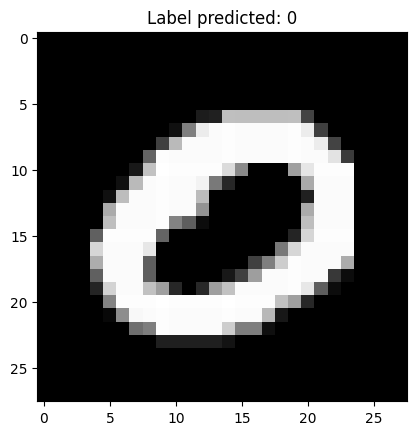

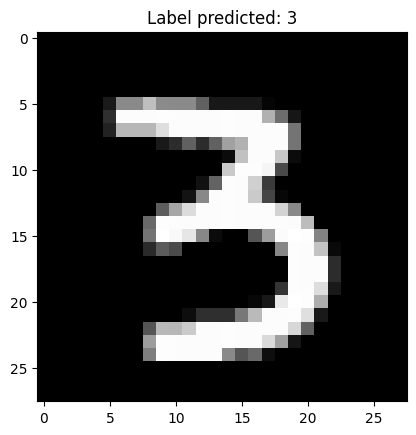

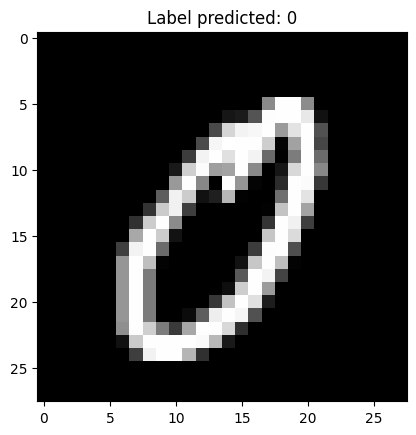

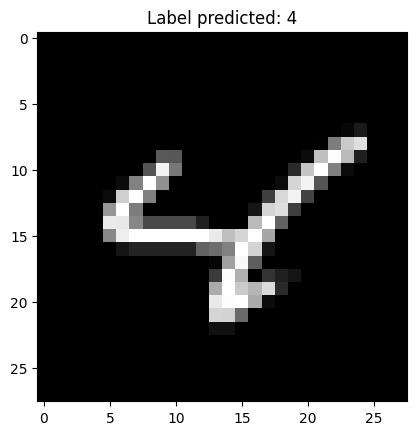

In [82]:
import random



# Tạo danh sách 5 số nguyên ngẫu nhiên trong khoảng 0 đến số lượng mẫu trong test_df

random_numbers = [random.randint(0, test_df.values.shape[0] - 1) for _ in range(5)]



# Hiển thị và dự đoán nhãn cho 5 mẫu ngẫu nhiên

for index in random_numbers:

    # Hiển thị ảnh với kích thước 28x28

    plt.imshow(test_df.values[index].reshape(28, 28), cmap='gray')

    # Dự đoán nhãn

    prediction = model.predict(test_df.values[index].reshape(1, -1))

    plt.title(f"Label predicted: {prediction[0]}")

    plt.show()


In [101]:
# handle submission 
predictions_test_df = svm.predict(x_test_final_pca)

In [102]:
predictions_test_df

array([2, 0, 8, ..., 3, 9, 2])

In [103]:
df=pd.DataFrame(predictions_test_df,columns=['Label'],index=np.arange(1,28001))
df.to_csv('subimission.csv',index_label='ImageId')